In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 데이터셋 경로 설정
dataset_dir = "/home/yycho/deepMUC/202230727_Image/Endoscopy_bak/train"
dataset_dir = Path(dataset_dir)

# 이미지 파일 경로 수집
filepaths = list(dataset_dir.glob(r'*/*.jpg'))
print(f"총 {len(filepaths)}개의 이미지 파일을 찾았습니다.")

# 데이터프레임 생성
def create_image_df(filepaths):
    labels = [filepath.parent.name for filepath in filepaths]
    df = pd.DataFrame({'Filepath': filepaths, 'Label': labels})
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # 데이터프레임 셔플
    return df

image_df = create_image_df(filepaths)
print(image_df.head())

# 레이블 인코딩
label_encoder_img = LabelEncoder()
image_df['Encoded_Label'] = label_encoder_img.fit_transform(image_df['Label'])  # 'High' => 0, 'Low' => 1

# 원-핫 인코딩
image_df['Categorical_Label'] = list(to_categorical(image_df['Encoded_Label']))


총 10569개의 이미지 파일을 찾았습니다.
                                            Filepath   Label
0  /home/yycho/deepMUC/202230727_Image/Endoscopy_...     MUC
1  /home/yycho/deepMUC/202230727_Image/Endoscopy_...     MUC
2  /home/yycho/deepMUC/202230727_Image/Endoscopy_...     MUC
3  /home/yycho/deepMUC/202230727_Image/Endoscopy_...  NONMUC
4  /home/yycho/deepMUC/202230727_Image/Endoscopy_...  NONMUC


In [2]:
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df
df = proc_img(filepaths)
df.head(2)

,Filepath,Label
0,/home/yycho/deepMUC/202230727_Image/Endoscopy_...,MUC
1,/home/yycho/deepMUC/202230727_Image/Endoscopy_...,MUC


In [3]:
from sklearn.model_selection import train_test_split

X_image_paths = image_df['Filepath'].astype(str).values
y_image = np.stack(image_df['Categorical_Label'].values)

# 학습용과 테스트용 데이터 분할
X_image_train_paths, X_image_test_paths, y_image_train, y_image_test = train_test_split(
    X_image_paths, y_image, test_size=0.2, random_state=42, stratify=y_image
)

print(f"학습용 이미지 데이터 수: {len(X_image_train_paths)}")
print(f"테스트용 이미지 데이터 수: {len(X_image_test_paths)}")


학습용 이미지 데이터 수: 8455
테스트용 이미지 데이터 수: 2114


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# 데이터 증강 및 전처리를 위한 ImageDataGenerator 설정
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input
)

# 제너레이터 함수 정의
def create_generator(filepaths, labels, datagen, batch_size):
    num_samples = len(filepaths)
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            batch_filepaths = filepaths[batch_indices]
            batch_labels = labels[batch_indices]
            batch_images = []
            for filepath in batch_filepaths:
                img = tf.keras.preprocessing.image.load_img(filepath, target_size=(299, 299))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                batch_images.append(img_array)
            batch_images = np.array(batch_images)
            batch_images = datagen.standardize(batch_images)
            yield batch_images, batch_labels


In [5]:
from tensorflow.keras.applications import DenseNet201, InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# 모델 구성
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)  # 클래스 수에 따라 조정
image_model = Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일
image_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 콜백 설정
checkpoint = ModelCheckpoint('image_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# 배치 크기와 스텝 계산
batch_size = 32
train_steps = len(X_image_train_paths) // batch_size
test_steps = len(X_image_test_paths) // batch_size

# 제너레이터 생성
train_generator = create_generator(X_image_train_paths, y_image_train, train_datagen, batch_size)
test_generator = create_generator(X_image_test_paths, y_image_test, test_datagen, batch_size)

# 모델 학습
history_img = image_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=test_generator,
    validation_steps=test_steps,
    epochs=50,
    callbacks=[checkpoint, reduce_lr, early_stop]
)


2024-10-28 21:04:49.383924: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 21:04:49.917824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79048 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


Epoch 1/50


2024-10-28 21:05:06.551637: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8906
2024-10-28 21:05:07.739831: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 0.3716 - accuracy: 0.8224
Epoch 1: val_accuracy improved from -inf to 0.82765, saving model to image_model.h5
264/264 [==============================] - 123s 413ms/step - loss: 0.3716 - accuracy: 0.8224 - val_loss: 0.4751 - val_accuracy: 0.8277 - lr: 1.0000e-04
Epoch 2/50
264/264 [==============================] - ETA: 0s - loss: 0.1800 - accuracy: 0.9314
Epoch 2: val_accuracy did not improve from 0.82765
264/264 [==============================] - 106s 399ms/step - loss: 0.1800 - accuracy: 0.9314 - val_loss: 0.4634 - val_accuracy: 0.8059 - lr: 1.0000e-04
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9603
Epoch 3: val_accuracy improved from 0.82765 to 0.91383, saving model to image_model.h5
264/264 [==============================] - 107s 408ms/step - loss: 0.1066 - accuracy: 0.9603 - val_loss: 0.2359 - val_accuracy: 0.9138 - lr: 1.0000e-04
Epoch 4/50
264/264 [=========================

In [6]:
# 최적의 모델 로드
best_image_model = tf.keras.models.load_model('image_model.h5')

# 테스트 데이터 평가
test_loss, test_accuracy = best_image_model.evaluate(test_generator, steps=test_steps)
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")


66/66 [==============================] - 23s 322ms/step - loss: 0.1349 - accuracy: 0.9669
테스트 손실: 0.13487257063388824
테스트 정확도: 0.966856062412262


In [7]:
# 모델을 지정된 경로에 저장
best_image_model.save('/home/yycho/deepMUC/202230727_Image/image_model.h5')


In [10]:
history_img_path = os.path.join(dataset_dir, "ga_MUC_NONMUC.npy")

np.save(history_img_path, history_img.history)

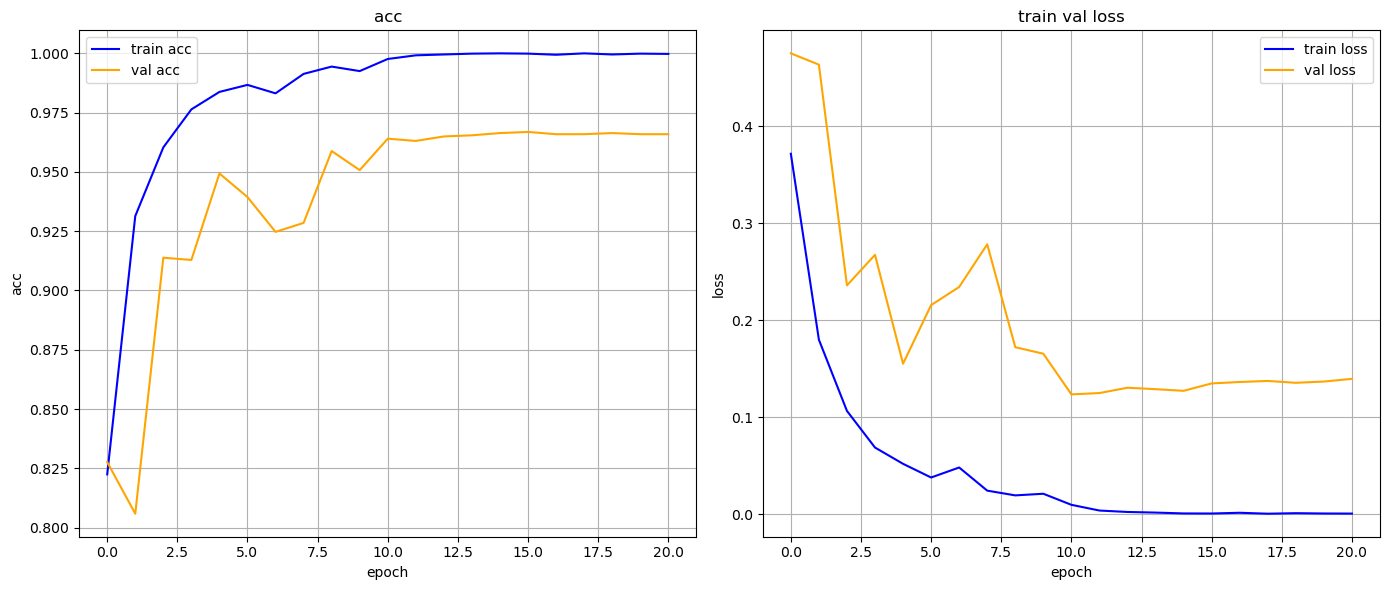

In [14]:
import matplotlib.pyplot as plt

# 훈련 히스토리 로드
history = np.load(history_img_path, allow_pickle=True).item()

# 정확도 및 손실 그래프 그리기
plt.figure(figsize=(14, 6))

# 정확도
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='train acc', color='blue')
plt.plot(history['val_accuracy'], label='val acc', color='orange')
plt.title('acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.grid(True)

# 손실
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='train loss', color='blue')
plt.plot(history['val_loss'], label='val loss', color='orange')
plt.title('train val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
#plt.savefig(os.path.join(save_dir, "Dense_training_history.png"))